# BNL Development Notebook

This notebook is for developing and testing the BNL package.


In [2]:
%load_ext autoreload
%autoreload 2

import bnl

# R2_BUCKET_PUBLIC_URL = "https://pub-05e404c031184ec4bbf69b0c2321b98e.r2.dev"
slm_ds_local = bnl.data.Dataset(manifest_path="~/data/salami/metadata.csv")
# slm_ds_cloud = bnl.data.Dataset(manifest_path=f"{R2_BUCKET_PUBLIC_URL}/manifest_cloud_boolean.csv")
track = next(iter(slm_ds_local))

In [3]:
## let's get an estimate hierarchy for a track:
# WIP this API should be better.
slm_ds = bnl.data.Dataset(manifest_path="~/data/salami/metadata.csv")
track = slm_ds[3]
# Let's check what annotations are available for this track
print("Available annotations:", list(track.annotations.keys()))

# Try loading an Adobe annotation that exists
est = track.load_annotation("adobe-mu1gamma1")
est

Available annotations: ['adobe-mu1gamma1', 'adobe-mu1gamma9', 'adobe-mu5gamma5', 'reference']


TS(B(0.0)-B(276.63673), adobe-mu1gamma1)

<Axes: title={'center': 'ref-5'}, xlabel='Time (s)'>

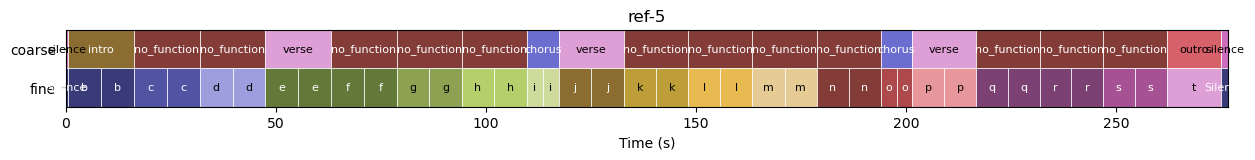

In [4]:
ref = track.load_annotation("reference")
ref.plot()

<Axes: title={'center': 'adobe-mu1gamma1'}, xlabel='Time (s)'>

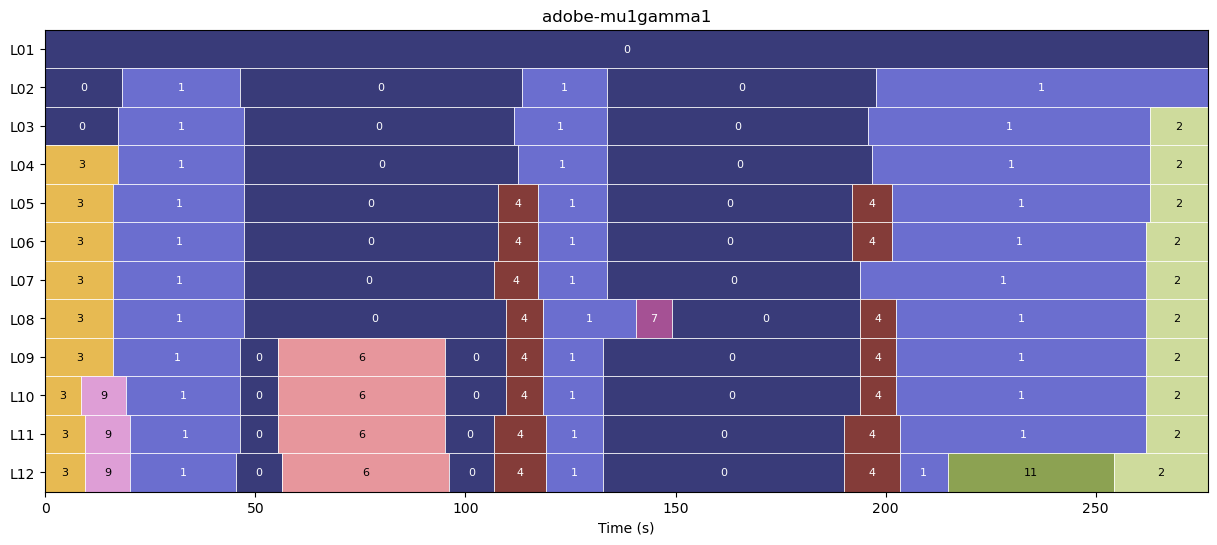

In [24]:
est.plot()
# est[3].plot()

<Axes: title={'center': 'adobe-mu1gamma1'}, xlabel='Time (s)'>

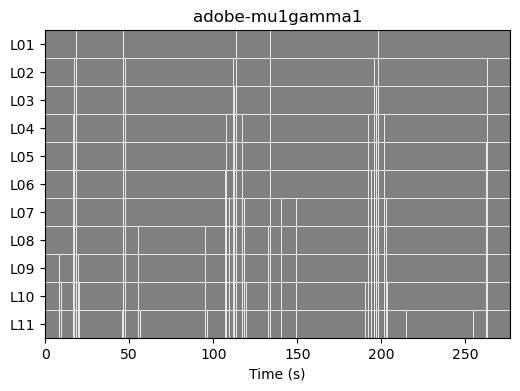

In [62]:
bh = bnl.ops.default_salience(est)
bh = bnl.ops.default_levels(bh)

mono_ms = bh.to_multisegment()
mono_ms.plot(figsize=(6, 4))

<Axes: title={'center': 'adobe-mu1gamma1'}, xlabel='Time (s)'>

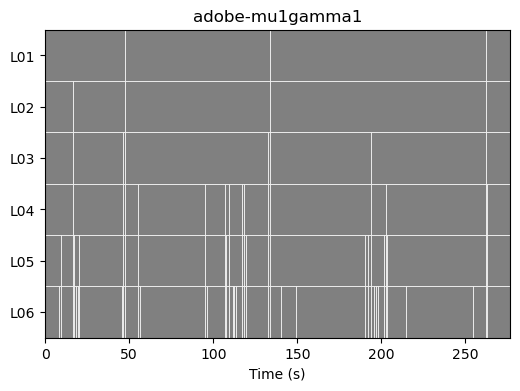

In [33]:
bh = bnl.ops.salience_by_counting(est)
bh = bnl.ops.default_levels(bh)
mono_ms = bh.to_multisegment()
mono_ms.plot(figsize=(6, 4))

<Axes: title={'center': 'adobe-mu1gamma1'}, xlabel='Time (s)'>

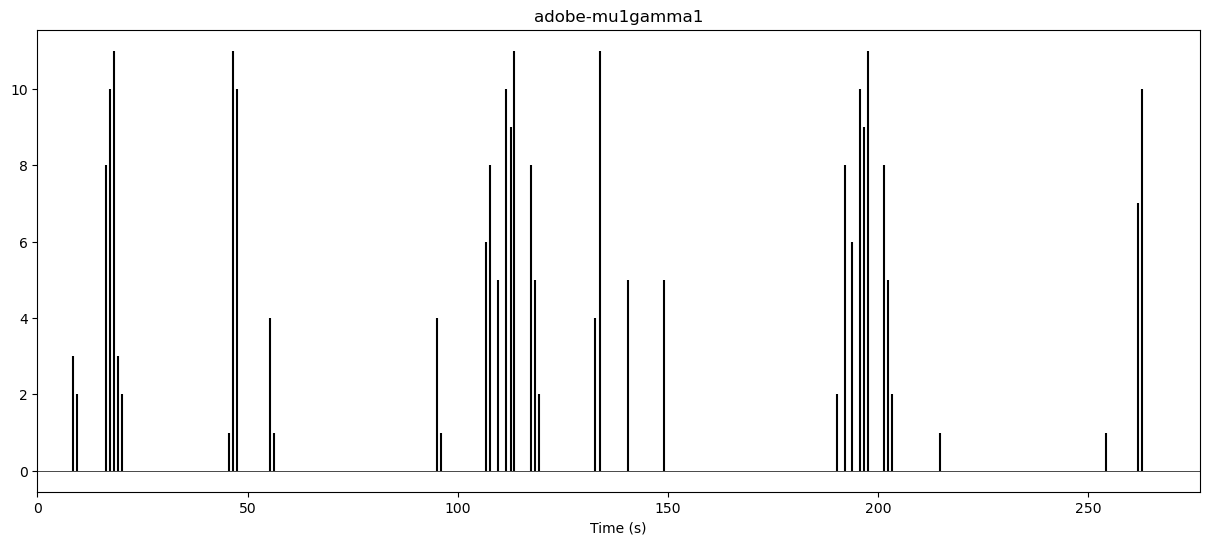

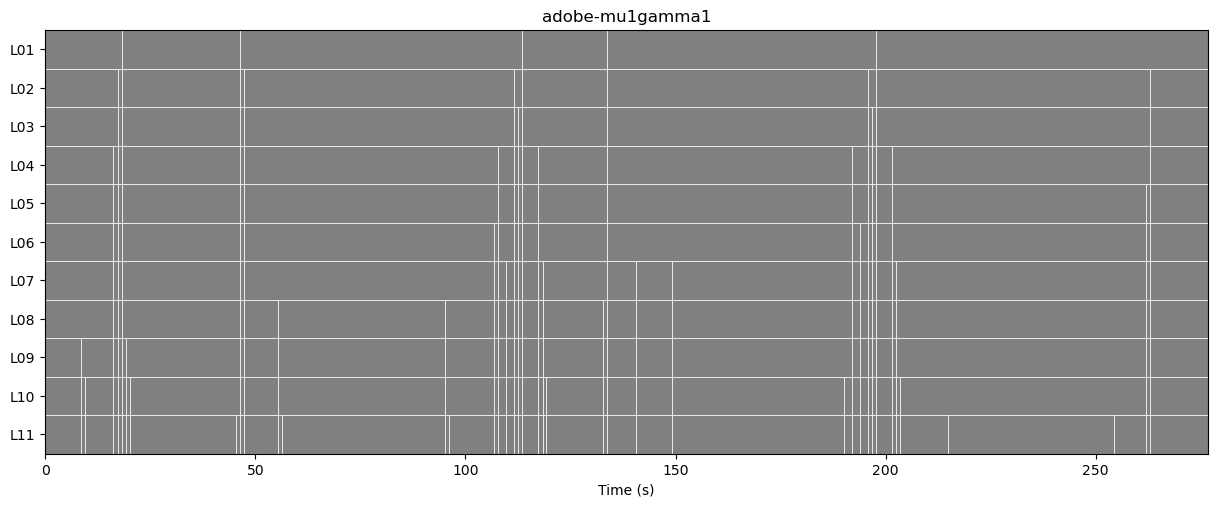

In [65]:
bh.plot()
bh.to_multisegment().plot()